# Prepare dataset

In [1]:
# Read data
import json
file_path = "instruction-data.json"

with open(file_path, "r") as file:
        data = json.load(file)

In [2]:
print(data[0])

{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.', 'input': 'freind --> friend', 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}


In [3]:
import torch
from torch.utils.data import Dataset

# # Apply alpaca prompt style
# def format_input(entry):
#     instruction_text = (
#         f"Below is an instruction that describes a task. "
#         f"Write a response that appropriately completes the request."
#         f"\n\n### Instruction:\n{entry['instruction']}"
#     )
#     input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
#     return instruction_text + input_text

# Apply phi-3 prompt style
def format_input(entry):
    instruction_text = (
        f"<|user|>\n{entry['instruction']}"
    )
    input_text = f"\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

In [4]:
# model_input = format_input(data[0])
# desired_response = f"\n\n### Response:\n{data[50]['output']}"
# print(model_input + desired_response)

model_input = format_input(data[0])
desired_response = f"\n\n<|assistant|>\n{data[0]['output']}"
print(model_input + desired_response)

<|user|>
Evaluate the following phrase by transforming it into the spelling given.
freind --> friend

<|assistant|>
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [5]:
# Partitioning the dataset

train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1) # 10%
val_portion = len(data) - train_portion - test_portion # 5%

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [6]:
# Batching the dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            # response_text = f"\n\n### Response:\n{entry['output']}"
            response_text = f"\n\n<|assistant|>\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer

checkpoint = "HuggingFaceTB/SmolLM-135M-Instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir="./.cache")

print(tokenizer.eos_token_id)
print(tokenizer.vocab_size)

2
49152


In [8]:
# Custom collate function

def custom_collate_fn(
    batch,
    pad_token_id=tokenizer.eos_token_id,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [9]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_fn(batch))

(tensor([[0, 1, 2, 3, 4],
        [5, 6, 2, 2, 2],
        [7, 8, 9, 2, 2]]), tensor([[   1,    2,    3,    4, -100],
        [   6,    2, -100, -100, -100],
        [   8,    9,    2, -100, -100]]))


In [10]:
if torch.cuda.is_available():
    device = "cuda"
# elif torch.backends.mps.is_available():
#     device = "mps"
else:
    device = "cpu"
    
print("Device:", device)

Device: cuda


In [11]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [12]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [13]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 42]) torch.Size([8, 42])
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 54]) torch.Size([8, 54])
torch.Size([8, 48]) torch.Size([8, 48])
torch.Size([8, 55]) torch.Size([8, 55])
torch.Size([8, 56]) torch.Size([8, 56])
torch.Size([8, 59]) torch.Size([8, 59])
torch.Size([8, 47]) torch.Size([8, 47])
torch.Size([8, 41]) torch.Size([8, 41])
torch.Size([8, 55]) torch.Size([8, 55])
torch.Size([8, 48]) torch.Size([8, 48])
torch.Size([8, 48]) torch.Size([8, 48])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 53]) torch.Size([8, 53])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 55]) torch.Size([8, 55])
torch.Size([8, 50]) torch.Size([8, 50])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 47]) torch.Size([8, 47])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 48]) torch.Size([8, 48])
torch.Size([8, 45]) torch.Size([8, 45])
torch.Size([8, 54]) torch.

# Load pretrained model

In [14]:
from functools import partial

model = AutoModelForCausalLM.from_pretrained(checkpoint, cache_dir="./.cache", max_length=100).to(device)
model_generate = partial(model.generate, max_new_tokens=256, do_sample=False)

In [15]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

<|user|>
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [16]:
inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
outputs = model_generate(inputs)
outputs = tokenizer.decode(outputs[0])
print(outputs)

/lunit/home/pytholic/miniconda3/envs/llm_smollm/lib/python3.11/site-packages/transformers/generation/utils.py:1376: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|user|>
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Now, rewrite the sentence using the passive form: 'The chef cooks every day.'

The correct sentence is: 'The chef cooks every day.'<|im_end|>


# PEFT with LoRA

In [17]:
import math

class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        # Same initialization that is used for Linear layers in PyTorch
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))  
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha
 
    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

In [18]:
# A LinearWithLora layer to replace Linear layers

class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )
 
    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [19]:
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear): # Replace the Linear layer with LinearWithLoRA
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else: # Recursively apply the same function to child modules
            replace_linear_with_lora(module, rank, alpha) 

In [20]:
# Freeze the original model params

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")
 
for param in model.parameters():
    param.requires_grad = False
 
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 134,515,008
Total trainable parameters after: 0


In [21]:
# replace linear layers

replace_linear_with_lora(model, rank=16, alpha=16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 5,680,128


In [22]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576, padding_idx=2)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): LinearWithLoRA(
            (linear): Linear(in_features=576, out_features=576, bias=False)
            (lora): LoRALayer()
          )
          (k_proj): LinearWithLoRA(
            (linear): Linear(in_features=576, out_features=192, bias=False)
            (lora): LoRALayer()
          )
          (v_proj): LinearWithLoRA(
            (linear): Linear(in_features=576, out_features=192, bias=False)
            (lora): LoRALayer()
          )
          (o_proj): LinearWithLoRA(
            (linear): Linear(in_features=576, out_features=576, bias=False)
            (lora): LoRALayer()
          )
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): LinearWithLoRA(
            (linear): Linear(in_features=576, out_fe

# Finetuning the model

In [23]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    outputs = model(input_batch)
    logits = outputs.logits 
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = 1024
#     inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
# outputs = model.generate(inputs, max_new_tokens=100, temperature=0.6, top_p=0.92, do_sample=True, output_scores=True, return_dict_in_generate=True)
# outputs = tokenizer.decode(outputs.sequences[0])
# print(outputs)
    encoded = tokenizer.encode(start_context, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_generate(encoded)
        decoded_text = tokenizer.decode(outputs[0])
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [24]:
# check the initial loss

model.to(device)
torch.manual_seed(123)
 
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
 
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Training loss: 3.148827600479126
Validation loss: 3.1376442909240723


In [25]:
# Train the model

import time
 
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00004, weight_decay=0.1)
num_epochs = 2
 
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)
 
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.188, Val loss 2.235
Ep 1 (Step 000005): Train loss 1.425, Val loss 1.266
Ep 1 (Step 000010): Train loss 1.003, Val loss 1.166
Ep 1 (Step 000015): Train loss 0.996, Val loss 1.133
Ep 1 (Step 000020): Train loss 0.901, Val loss 1.116
Ep 1 (Step 000025): Train loss 0.920, Val loss 1.089
Ep 1 (Step 000030): Train loss 1.026, Val loss 1.061
Ep 1 (Step 000035): Train loss 0.932, Val loss 1.033
Ep 1 (Step 000040): Train loss 0.874, Val loss 1.014
Ep 1 (Step 000045): Train loss 0.768, Val loss 1.002
Ep 1 (Step 000050): Train loss 0.828, Val loss 0.980
Ep 1 (Step 000055): Train loss 0.959, Val loss 0.968
Ep 1 (Step 000060): Train loss 0.928, Val loss 0.954
Ep 1 (Step 000065): Train loss 0.812, Val loss 0.944
Ep 1 (Step 000070): Train loss 0.732, Val loss 0.941
Ep 1 (Step 000075): Train loss 0.763, Val loss 0.945
Ep 1 (Step 000080): Train loss 0.786, Val loss 0.945
Ep 1 (Step 000085): Train loss 0.653, Val loss 0.939
Ep 1 (Step 000090): Train loss 0.635, Val loss

In [26]:
# Plot the loss
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.png")
    plt.show()

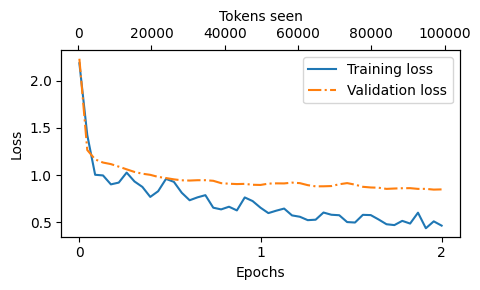

In [27]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [28]:
# Test some responses

torch.manual_seed(123)

for entry in test_data[:3]:

    input_text = format_input(entry)
    encoded = tokenizer.encode(input_text, return_tensors="pt").to(device)
    outputs = model_generate(encoded)
    # outputs = model.generate(encoded, max_new_tokens=256, temperature=0.6, top_p=0.92, do_sample=True)
    decoded_text = tokenizer.decode(outputs[0])
    # print(decoded_text.replace("\n", " "))  # Compact print format
    # response_text = (
    #     decoded_text[len(input_text):]
    #     .replace("### Response:", "")
    #     .replace(tokenizer.eos_token, "")
    #     .strip()
    # )
    response_text = (
        decoded_text[len(input_text):]
        .replace("<|im_start|>", "")
        .replace("<|im_end|>", "")
        .replace("<|assistant|>", "")
        .replace("<|endoftext|>", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

<|user|>
Rewrite the sentence using a simile.
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
<|user|>
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud that is typically associated with thunderstorms is cumulus.
-------------------------------------
<|user|>
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is Jane Austen.
-------------------------------------


# Saving model and responses for evaluation

In [29]:
# Save all responses for future evaluations

import json
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)
    encoded = tokenizer.encode(input_text, return_tensors="pt").to(device)
    outputs = model_generate(encoded)
    decoded_text = tokenizer.decode(outputs[0])
    # response_text = (
    #     decoded_text[len(input_text):]
    #     .replace("### Response:", "")
    #     .replace(tokenizer.eos_token, "")
    #     .strip()
    # )
    response_text = (
        decoded_text[len(input_text):]
        .replace("<|im_start|>", "")
        .replace("<|im_end|>", "")
        .replace("<|assistant|>", "")
        .replace("<|endoftext|>", "")
        .strip()
    )

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [01:15<00:00,  1.45it/s]


In [30]:
# import re

# file_name = "smollm-sft-lora.pth"
# torch.save(model.state_dict(), file_name)
# print(f"Model saved as {file_name}")